In [22]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x
dy_dx = g.gradient(y, x) # Will compute to 6.0
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [2]:
import tensorflow as tf
a = tf.Variable(1, name = "a")
b = tf.Variable(2, name = "b")
f = a + b

tf.print("The sum of a and b is ",f)

The sum of a and b is  3


f is the graph of the relationship between a and b

Unlike normal Python, tensorflow does not run the code until print

We will now play around with 70k images mimicking digits 0-9. We will identify which digit each image represents

In [4]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [1]:
import numpy as np
import tensorflow as tf

#dataset parameters
num_class = 10 #digits 0-9
num_features = 784 #image shape = 28 * 28

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#convert data type
x_train = np.array(x_train, np.float32)
x_test = np.array(x_test, np.float32)

#flatten image to 1D vector (784 features)
x_train = x_train.reshape([-1,num_features])
x_test = x_test.reshape([-1,num_features])

#normalizing values (255 colors)
x_train = x_train / 255.
x_test = x_test / 255.

This is to visualize the input data

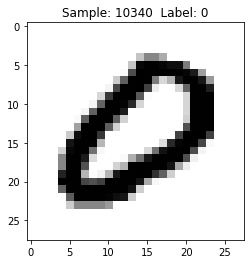

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def display_sample(num):
    label = y_train[num]
    
    #reshape to 2D
    image = x_train[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap = plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(10340)

In [2]:
#training parameters
learning_rate = .001 #how quickly we find optimal value in gradient descent
training_steps = 3000 #how many training epochs
batch_size = 250 #how many random samples for each step
display_step = 100 #how often do we display progress
n_hidden = 512 # number of neurons

In [3]:
#Use tf.data API to shuffle and batch data
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1)

In [4]:
#store layers, weights and biases
random_normal = tf.initializers.RandomNormal()

weights = {
    'h' : tf.Variable(random_normal([num_features, n_hidden])), #input num_features independent variables, output n_hidden dependent variables
    'out' : tf.Variable(random_normal([n_hidden, num_class])) #these are all initial conditions
}
biases = {
    'b' : tf.Variable(tf.zeros([n_hidden])),
    'out' : tf.Variable(tf.zeros([num_class]))
}

In [5]:
#topology of neuran network
def neural_net(inputData):
    #Hidden fully connected layer with 512 neurons
    hidden_layer = tf.add(tf.matmul(inputData, weights['h']), biases['b']) #matrix multiplication of input values (784 components)
        #these weights and biases are global variables since they can change irrespective of this function
    # apply sigmoid to hidden_layer output for non-linearity
    hidden_layer = tf.nn.sigmoid(hidden_layer) #1 / (1 + exp(-hidden_layer))
    
    #Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(hidden_layer, weights['out']) + biases['out']
    # apply softmax to normalize the logits to a probability distribution
    return tf.nn.softmax(out_layer)

In [6]:
#we create a function to penalize wrong classification
def cross_entropy(y_pred,y_true):
    y_true = tf.one_hot(y_true, depth = num_class) #binary representation of being correct. example, 
        #example, [0,1,0,0] is the hot encoding of the second component being true
    y_pred = tf.clip_by_value(y_pred,1e-9,1.) #forces range of y_pred to be between 1e-9 AND 1. to avoid error with logarithm
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred))) #reduce_sum (mean) is just the sum (avg) of the components of a tensor #compute the whole batch

In [7]:
optimizer = tf.keras.optimizers.SGD(learning_rate) #stochastic gradient descent

def run_optimization(x,y):
    #calling coefficients to be called training variables
    trainable_variables = list(weights.values()) + list(biases.values())
    
    #GradientTape for automatic differentiation
    with tf.GradientTape() as g:
        g.watch(trainable_variables)
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
    
    #compute gradients
    gradients = g.gradient(loss, trainable_variables) #d loss / d trainable_variables
    
    #update W and b following gradients
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [9]:
optimizer = tf.keras.optimizers.SGD(learning_rate) #stochastic gradient descent

def run_optimization(x,y):
    #GradientTape for automatic differentiation
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
    #calling coefficients to be called training variables
    trainable_variables = list(weights.values()) + list(biases.values())
    
    #compute gradients
    gradients = g.gradient(loss, trainable_variables)
    
    #update W and b following gradients
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
#try to find a way 
#accuracy metric
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1),tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis = -1)

In [11]:
x = batch_x
y = batch_y
with tf.GradientTape() as g:
    pred = neural_net(x)
    loss = cross_entropy(pred,y)
    #loss = cross_entropy(pred, y)
#calling coefficients to be called training variables
trainable_variables = list(weights.values()) + list(biases.values())
gradients = g.gradient(loss, trainable_variables)

In [9]:
#run training for given number of steps
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # run optimization to update weights and biases
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("Training epoch: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))

Training epoch: 100, Loss: 170.757004, Accuracy: 0.800000
Training epoch: 200, Loss: 114.144844, Accuracy: 0.880000
Training epoch: 300, Loss: 111.345543, Accuracy: 0.888000
Training epoch: 400, Loss: 93.130890, Accuracy: 0.892000
Training epoch: 500, Loss: 98.962006, Accuracy: 0.880000
Training epoch: 600, Loss: 93.651627, Accuracy: 0.924000
Training epoch: 700, Loss: 69.950241, Accuracy: 0.884000
Training epoch: 800, Loss: 80.495132, Accuracy: 0.908000
Training epoch: 900, Loss: 78.070717, Accuracy: 0.904000
Training epoch: 1000, Loss: 76.051369, Accuracy: 0.920000
Training epoch: 1100, Loss: 91.429382, Accuracy: 0.888000
Training epoch: 1200, Loss: 66.085480, Accuracy: 0.932000
Training epoch: 1300, Loss: 71.626724, Accuracy: 0.924000
Training epoch: 1400, Loss: 69.719650, Accuracy: 0.928000
Training epoch: 1500, Loss: 63.749527, Accuracy: 0.932000
Training epoch: 1600, Loss: 50.071594, Accuracy: 0.936000
Training epoch: 1700, Loss: 53.166504, Accuracy: 0.920000
Training epoch: 1800

In [83]:
#Test model on validation set
pred = neural_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.967300


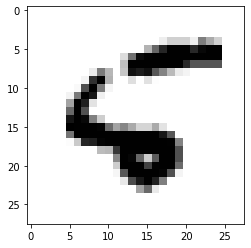

Original Labels: 5
Model prediction: 6


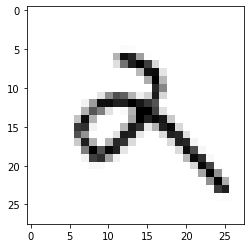

Original Labels: 2
Model prediction: 9


In [84]:
#see mistakes
n_images = 200
test_images = x_test[:n_images]
test_labels = y_test[:n_images]
prediction = neural_net(test_images)

for i in range(n_images):
    model_prediction = np.argmax(prediction.numpy()[i])
    if (model_prediction != test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap = 'gray_r')
        plt.show()
        print("Original Labels: %i" % test_labels[i])
        print("Model prediction: %i" % model_prediction)